In [1]:
from preprocessing_function_TodasCategorias import *
from functions_MARISA import *

c:\Users\rodri\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
%run functions_MARISA.py

In [3]:
import numpy as np

from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, ElasticNet, HuberRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import RFE

from math import ceil

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, root_mean_squared_error

from sklearn.metrics import make_scorer

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

import time

import warnings
warnings.filterwarnings('ignore')




In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train.set_index('carID', inplace=True)
df_test.set_index('carID', inplace=True)

In [6]:
random_state = 42

## Pre-Processing

We start by defining the inconsistent values discussed in the EDA as NA:

In [7]:
df_train.loc[df_train['year']>2020, 'year'] = np.nan
df_test.loc[df_test['year']>2020, 'year'] = np.nan

df_train.loc[df_train['mileage']<0, 'mileage'] = np.nan
df_test.loc[df_test['mileage']<0, 'mileage'] = np.nan

df_train.loc[df_train['tax']<0, 'tax'] = np.nan
df_test.loc[df_test['tax']<0,'tax'] = np.nan

df_train.loc[df_train['mpg']<=0, 'mpg'] = np.nan
df_test.loc[df_test['mpg']<=0, 'mpg'] = np.nan

df_train.loc[df_train['paintQuality%']>100, 'paintQuality%'] = np.nan
df_test.loc[df_test['paintQuality%']>100, 'paintQuality%'] = np.nan

df_train.loc[df_train['previousOwners']< 0, 'previousOwners'] = np.nan
df_test.loc[df_test['previousOwners']< 0, 'previousOwners'] = np.nan

df_train.loc[df_train['engineSize']<= 0, 'engineSize'] = np.nan
df_test.loc[df_test['engineSize']<= 0, 'engineSize'] = np.nan

df_train.loc[df_train['mpg'] < 40, 'mpg'] = np.nan
df_train.loc[df_train['engineSize'] < 1, 'engineSize'] = np.nan

df_test.loc[df_test['mpg'] < 40, 'mpg'] = np.nan
df_test.loc[df_test['engineSize'] < 1, 'engineSize'] = np.nan

We proceed to round 'year' and 'previousOwners' to whole numbers using the floor function. Other numerical features are rounded to 2 decimal points.

In [8]:
df_train['year'] = np.floor(df_train['year'])
df_train['previousOwners'] = np.floor(df_train['previousOwners'])

df_test['year'] = np.floor(df_test['year'])
df_test['previousOwners'] = np.floor(df_test['previousOwners'])

for feat in ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%']:
    df_train[feat] = df_train[feat].round(2)
    df_test[feat] = df_test[feat].round(2)

We also pre-process the categorical variables in order to have a uniform format for later treatment (inside k-fold CV). We remove leeading and trailing spaces and uppercase all letters.

In [9]:
# Pre processing the categorical variables to be easier to find clusters in typos:
    # remove spaces (at the beginning and end) and uppercase all letters
    # does not replace NaN's
df_train['Brand'] = df_train['Brand'].where(df_train['Brand'].isna(), df_train['Brand'].astype(str).str.strip().str.upper())
df_test['Brand']  = df_test['Brand'].where(df_test['Brand'].isna(), df_test['Brand'].astype(str).str.strip().str.upper())

df_train['model'] = df_train['model'].where(df_train['model'].isna(), df_train['model'].astype(str).str.strip().str.upper())
df_test['model']  = df_test['model'].where(df_test['model'].isna(), df_test['model'].astype(str).str.strip().str.upper())

df_train['fuelType'] = df_train['fuelType'].where(df_train['fuelType'].isna(), df_train['fuelType'].astype(str).str.strip().str.upper())
df_test['fuelType']  = df_test['fuelType'].where(df_test['fuelType'].isna(), df_test['fuelType'].astype(str).str.strip().str.upper())

df_train['transmission'] = df_train['transmission'].where(df_train['transmission'].isna(), df_train['transmission'].astype(str).str.strip().str.upper())
df_test['transmission']  = df_test['transmission'].where(df_test['transmission'].isna(), df_test['transmission'].astype(str).str.strip().str.upper())

Drop informations given by the mechanic: 

In [10]:
df_train.drop ('paintQuality%', axis =1 , inplace =True)
df_test.drop ('paintQuality%', axis =1 , inplace =True)

In [11]:

y = df_train['price']
X = df_train.drop('price', axis=1)



Notas sobre as classes:

- variáveis criadas na inicialização não acabam em _; as ue são criadas dentro dos métodos acabam em _!
- criando uma var nos métodos, se ela não começar em self. não será reconhecida por toda a classe, será apenas local!
- logo, iniciar com self. para criar novos atributos gerais (assim transform() cconsegue aceder ao atributo criado em fit() por exemplo)
- cuidado com data leakage! :D

### Categorical_Correction Class

In [12]:

class Categorical_Correction(BaseEstimator, TransformerMixin):

    def __init__(self):  # initialize the transformer
        pass             # self it's how Python refers to the transformer within the class.
                         # self.something --> something its an attribute of the transformer.

    def fit(self, X, y=None): # fit is where we learn from the data
        """ Learns parameters from train data to then use in categorical variable correction inside 
        transformer function of this same class."""


        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        ###### -----------------------------------------------------BRAND----------------------------------------------------------------------######

        self.brands_ = X['Brand'].dropna().unique().tolist()

        _, self.mapping_brand_ = create_clusters(X, self.brands_, 'Brand')

        ######---------------------------------------------------TRANSMISSION--------------------------------------------------------------------######

        self.transmission_types_ = X['transmission'].dropna().unique().tolist()

        _, self.mapping_transmission_ = create_clusters(X, self.transmission_types_, 'transmission')


        ######----------------------------------------------------FUEL TYPE--------------------------------------------------------------------######

        self.fuel_types_= X['fuelType'].dropna().unique().tolist()

        _, self.mapping_fueltype_ = create_clusters(X, self.fuel_types_, 'fuelType')


        ######------------------------------------------------------MODELS----------------------------------------------------------------------######

        self.models_= X['model'].dropna().unique().tolist()

        ## Fuzzywuzzy wasn't able to group the same models in the column 'model', so for this case we will use get_close_matches from the difflib library.
        self.clusters_ = similar_models(self.models_)

        # Calculate counts once before the function
        self.model_counts_ = X['model'].value_counts().to_dict()

        # List to store the most frequent model in each cluster which will be considered the correct one
        self.correct_models_ = []

        #   Dictionary to map each model to its correct version
        self.model_mapping_ = {}

        # For loop to go over all the clusters 
        for group in self.clusters_:

            # The best model of each cluster will be the one with the highest count in the train set, it will be added to the correct_models list
            best = max(group, key=lambda x: self.model_counts_.get(x, 0))
            self.correct_models_.append(best)

            # Map all models in the group to the best model
            for model in group:
                self.model_mapping_[model] = best

        return self
    


    def transform(self, X): # transform is where we apply the learned parameters to correct the data

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # BRAND----------------------------------------------------------------------------------------------

        # We first correct the 'W' brands which should be either VW or BMW
        # this correction does not depent on params learned from train data:
        X['Brand'] = X.apply(lambda row: correct_brand_w(X, row['Brand'], row['model']),axis=1)
        # for cars with no model where correct_brand_w doesn't work:
        X.loc[X['Brand'] =='W' ,'Brand'] = 'VW'

        # Remaining typos:
        X['Brand_cleaned'] = X['Brand'].apply(lambda x: correct_categorical(self.mapping_brand_, x))

        # TRANSMISSION---------------------------------------------------------------------------------------
        X['transmission_cleaned'] = X['transmission'].apply(lambda x: correct_categorical(self.mapping_transmission_, x))


        # FUELTYPE -------------------------------------------------------------------------------------------
        X['fuelType_cleaned'] = X['fuelType'].apply(lambda x: correct_categorical(self.mapping_fueltype_, x))


        # MODEL ---------------------------------------------------------------------------------------------
        X['model_cleaned'] = X['model'].apply(lambda x: correct_column_model(self.correct_models_, self.model_mapping_, x, self.clusters_))


        # Finally, we drop the variables with typos:
        X = X.drop(['Brand', 'model', 'transmission', 'fuelType'], axis=1)


        return X



### Outlier_Treatment Class

In [13]:
class Outlier_Treatment(BaseEstimator, TransformerMixin):

    def __init__(self, dim=3, ratio = 0.00008):
        self.feat_lst = ['tax', 'mileage', 'mpg', 'engineSize', 'year', 'previousOwners']
        self.dim = dim
        self.ratio = ratio

    def fit(self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.outlier_limits_ = {}
        self.quantiles_ = {}

        for feat in self.feat_lst:
            Q1 = X[feat].quantile(0.25)
            Q3 = X[feat].quantile(0.75)
            IQR = Q3 - Q1
            self.outlier_limits_[feat] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
            self.quantiles_[feat] = (X[feat].quantile(0.01),X[feat].quantile(0.99))
            

        return self
    
    def transform(self, X):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        outlier_counts = pd.Series(0, index=X.index)

        for feat in self.feat_lst:

            upper = self.outlier_limits_[feat][1]
            lower = self.outlier_limits_[feat][0]

            # counting in how many feats each point is an outlier 
            #outlier_counts += ((X[feat] < lower) | (X[feat] >  upper)).astype(int)


            if X[X[feat] > upper].shape[0]/ X.shape[0] >= self.ratio:
                X.loc[X[feat] > upper, feat] = self.quantiles_[feat][1]

            if X[X[feat] < lower].shape[0]/ X.shape[0] >= self.ratio:
                X.loc[X[feat] < lower, feat] = self.quantiles_[feat][0]


        return X
    




### Missing_Value_Treatment Class

In [14]:
class Missing_Value_Treatment(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)


        # Missing BRAND ---------------------------------------------------------------------------------
        self.brand_mode_ = X['Brand_cleaned'].mode().iloc[0]
        self.model_to_brand_ = (X.dropna(subset=['Brand_cleaned', 'model_cleaned'])
                            .groupby('model_cleaned')['Brand_cleaned']
                            .agg(lambda x: x.mode().iloc[0])  # get most frequent brand for each model
                            .to_dict())

        # Missing MODEL ---------------------------------------------------------------------------------
        self.model_maps_ = build_model_mappings(X)

        # Missing YEAR ---------------------------------------------------------------------------------
        self.bins_ = X['mileage'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
        self.labels_ = ['very low', 'low', 'average', 'high', 'very high']
        self.year_median_ = X['year'].median()

        X['mileage_bin'] = pd.cut(X['mileage'], bins=self.bins_, labels=self.labels_, include_lowest=True)

        self.year_map_mileage_ = (X.dropna(subset=['year', 'mileage_bin']).groupby('mileage_bin', observed=False)['year'].median().to_dict())

        self.year_map_tax_ = (X.dropna(subset=['year', 'tax']).groupby('tax', observed=False)['year'].median().to_dict())

        self.year_map_mpg_ = (X.dropna(subset=['year', 'mpg']).groupby('mpg', observed=False)['year'].median().to_dict())

        # Missing MILEAGE ---------------------------------------------------------------------------------
        self.mileage_map_ = (X.dropna(subset=['mileage','year']).groupby(['year'])['mileage'].median().to_dict())

        # Missing TAX --------------------------------------------------------------------------------
        self.tax_maps_ = build_tax_mappings(X)

        # Missing FUELTYPE --------------------------------------------------------------------------------
        self.fueltype_maps_ = build_fuel_mappings(X)

        # Missing MPG -----------------------------------------------------------------------------------------
        self.mpg_maps_ = build_mpg_mappings(X)

        # Missing ENGINE SIZE --------------------------------------------------------------------------------
        self.enginesize_maps_ = build_engine_mappings(X)

        # Missing PREVIOUS OWNERS --------------------------------------------------------------------------------
        self.previous_owners_maps_ = build_owners_mappings(X)

        # Missing TRANSMISSION --------------------------------------------------------------------------------
        self.transmission_maps_ = build_transmission_mappings(X)

        # Missing HASDAMAGE --------------------------------------------------------------------------------
        # We just replace NaN values with True in transform()

        return self

    def transform(self, X):
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if 'mileage_bin' in X.columns:
            X = X.drop('mileage_bin', axis=1)

        # Missing BRAND --------------------------------------------------------------------------------
        X['Brand_cleaned'] = X.apply(lambda row: impute_brand(row, self.model_to_brand_, self.brand_mode_),axis=1)

        # Missing MODEL --------------------------------------------------------------------------------
        X['model_cleaned'] = X.apply(lambda row: impute_model_flexible(row, self.model_maps_),axis=1)

        # Missing YEAR --------------------------------------------------------------------------------
        X['mileage_bin'] = pd.cut(X['mileage'], bins=self.bins_, labels=self.labels_, include_lowest=True)

        X['year'] = X.apply(lambda row: impute_year(row, self.year_map_mileage_, self.year_map_tax_, self.year_map_mpg_, self.year_median_),axis=1)

        X = X.drop('mileage_bin', axis= 1)

        # Missing MILEAGE --------------------------------------------------------------------------------
        X['mileage'] = X.apply(lambda row: impute_mileage(row, self.mileage_map_), axis=1)

        # Missing TAX --------------------------------------------------------------------------------
        X['tax'] = X.apply(lambda row: impute_tax(row, self.tax_maps_), axis=1)

        # Missing FUELTYPE --------------------------------------------------------------------------------
        X['fuelType_cleaned'] = X.apply(lambda row: impute_fueltype(row, self.fueltype_maps_),axis=1)

        # Missing MPG --------------------------------------------------------------------------------
        X['mpg'] = X.apply(lambda row: impute_mpg(row, self.mpg_maps_), axis=1)

        # Missing ENGINESIZE --------------------------------------------------------------------------------
        X['engineSize'] = X.apply(lambda row: impute_engine(row, self.enginesize_maps_), axis=1)

        # Missing PREVIOUS OWNERS --------------------------------------------------------------------------------
        X['previousOwners'] = X.apply(lambda row: impute_owners(row, self.previous_owners_maps_), axis=1)

        # Missing TRANSMISSION --------------------------------------------------------------------------------
        X['transmission_cleaned'] = X.apply(lambda row: impute_transmission(row, self.transmission_maps_),axis=1)

        # Missing HASDAMAGE --------------------------------------------------------------------------------
        X['hasDamage'] = X['hasDamage'].fillna(True)

        return X


### Typecasting Class

In [15]:
class Typecasting(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return self 

    def transform(self, X):
        X = X.copy()
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X['year'] = X['year'].astype(int)
        X['previousOwners'] = X['previousOwners'].astype(int)
        X['hasDamage'] = X['hasDamage'].astype(bool) 
        
        return X


### Feature_Engineering Class:

In [16]:
class Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        df_temp = X.copy()
        df_temp['price'] = y.values
        brand_price = df_temp.groupby('Brand_cleaned')['price'].mean().sort_values()
        economy_limit = brand_price.quantile(0.33)
        semi_premium_limit = brand_price.quantile(0.66)

        self.segment_ = {brand: (1 if price <= economy_limit else 2 if price <= semi_premium_limit else 3) for brand, price in brand_price.items()}

        return self 

    def transform(self, X):
        X = X.copy()
        
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Car Age
        X['carAge'] = (2020 - X['year']).round(0).astype(int)

        # Average Car Usage
        X['AvgUsage'] = X['mileage'] / (X['carAge'] +1)

        # Car Segment based on Brand
        X['carSegment'] = X['Brand_cleaned'].map(self.segment_)

        return X

### Encoder Class

In [17]:
class Encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # features encoded by target encoding:
        self.target_features_ = ['model_cleaned','Brand_cleaned']

        self.encoder_ = TargetEncoder(categories="auto" , target_type="continuous" ) 
        self.encoder_.fit(X[self.target_features_], y)

        # features encoded by one-hot encoding:
        self.one_hot_features_ = ['fuelType_cleaned', 'transmission_cleaned']

        self.encoder_fueltype_ = OneHotEncoder(categories="auto" , handle_unknown="ignore", sparse_output=False).set_output(transform='pandas')
        self.encoder_fueltype_.fit(X[['fuelType_cleaned']])

        self.encoder_transmission_ = OneHotEncoder(categories="auto" , handle_unknown="ignore", sparse_output=False).set_output(transform='pandas')
        self.encoder_transmission_.fit(X[['transmission_cleaned']])

        return self

    def transform(self, X):
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # target
        X[[f'{feat}_encoded' for feat in self.target_features_]] = self.encoder_.transform(X[self.target_features_])

        # one_hot
        self.dummies_fueltype_ = self.encoder_fueltype_.transform(X[['fuelType_cleaned']])
        self.dummies_transmission_ = self.encoder_transmission_.transform(X[['transmission_cleaned']])

        X = pd.concat([X, self.dummies_fueltype_, self.dummies_transmission_], axis=1)

        X = X.drop(['Brand_cleaned', 'transmission_cleaned', 'fuelType_cleaned','model_cleaned'], axis=1)

        return X

### Scaler Class

In [18]:

class Scaler(BaseEstimator, TransformerMixin):

    def __init__(self, scaler=StandardScaler()):
        self.scaler = scaler

    def fit(self, X, y=None):

        X = X.copy()


        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.numeric_features_ = X.select_dtypes(include=[np.number]).columns.tolist()

        for feat in [c for c in self.numeric_features_ if c.startswith("fuelType")]:
            if feat in self.numeric_features_:
                self.numeric_features_.remove(feat)

        for feat in [c for c in self.numeric_features_ if c.startswith("transmission")]:
            if feat in self.numeric_features_:
                self.numeric_features_.remove(feat)
        
        self.scaler.fit(X[self.numeric_features_])

        return self

    def transform(self, X):

        X = X.copy()
        self.feature_names_in_ = X.columns


        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        
        X[self.numeric_features_] = self.scaler.transform(X[self.numeric_features_])

        return X







### Pre-processing complete: stack everything inside pipeline

### Feature_Selection Class

In [19]:
class Feature_Selection(BaseEstimator, TransformerMixin):

    def __init__(self, rfe_options=[8, 10], spearman_options=[0.2, 0.25, 0.3],var_threshold=0.01):

        self.rfe_options = rfe_options
        self.spearman_options = spearman_options
        self.var_threshold = var_threshold


    def fit(self, X, y=None):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)


        X['hasDamage'] = X['hasDamage'].astype(int)

        # From numerical features we keep only the ones with variance != 0 (non-constant)
        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

        non_constant_features = [f for f in numeric_features if X[f].var() > 0]

        results = []  # to store all combinations and MAE
        mae_scores = []

        features = [f for f in non_constant_features if X[f].var() > self.var_threshold]

        # Feature Importance
        tree = DecisionTreeRegressor()
        tree.fit(X = X[features], y= y)
        gini_importance = tree.feature_importances_
        selected_gini = [f for f, imp in zip (features, gini_importance) if imp > (1 / len(features))]

        # Loop over all parameter combinations
        for n_feats in self.rfe_options:
            for spearman_thr in self.spearman_options:
                mae_scores = []

                # Compute absolute Spearman correlation with target
                features_fold = X[features]
                corr_with_target = features_fold.apply(lambda x: x.corr(y, method='spearman'))
                selected_spearman = corr_with_target[abs(corr_with_target) > spearman_thr].index.tolist() # each index is a feature
                
                # Wrapper method: RFE with Linear Regression
                model = LinearRegression()
                rfe_lr = RFE(estimator=model, n_features_to_select=n_feats)
                rfe_lr.fit(X= X[features], y= y)
                rfe_lr_features = pd.Series(rfe_lr.support_, index=features)
                rfe_lr_features_list = rfe_lr_features[rfe_lr_features].index.tolist() # only chooses the features where RFE selected True


                # Majority vote: keep features that appear in more than or at least half of the methods
                feature_counts = {}
                for method in [selected_spearman, rfe_lr_features_list, selected_gini]:
                    for f in method:
                        feature_counts[f] = feature_counts.get(f,0)+1
                n_methods = len([selected_spearman, rfe_lr_features_list, selected_gini])
                threshold = n_methods//2 + n_methods%2
                final_features = [f for f,count in feature_counts.items() if count >= threshold]

                # Evaluate performance with selected features
                model = LinearRegression()
                model.fit(X[final_features], y)
                y_pred = model.predict(X[final_features])
                mae = mean_absolute_error(y, y_pred)
                mae_scores.append(mae)
                results.append({'features': final_features, 'mae': mae})

        # Select combination with lowest MAE
        self.best_ = min(results, key=lambda x: x['mae'])

        return self

    def transform(self, X):
        
        X = X.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        selected_features = self.best_['features']

        X = X[selected_features]

        return X

### PIPELINE

Ao fazer apenas categorial = Categorical Correction(), por exemplo, estamos a criar um objeto, não são aplicadas nenhumas transformações, nem é aprendido nada.

Ao fazer categorical.fit(X_train) estamos a aprender os parâmetros.

Ao fazer categorical.transform(X_train) são efetivamente feitas as alterações com base nas regras aprendidas em .fit().

In [20]:
model = GradientBoostingRegressor()
model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [21]:
pipeline = Pipeline([
    ('categorical treatment', Categorical_Correction()),  #using just feature selection
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()), 
    ('feature selection', Feature_Selection()),
    ('regressor', GradientBoostingRegressor(random_state=42 ) )
])


- Gradient Boosting is a machine learning technique that builds predictive models in a sequential manner by combining the predictions of multiple weak learners (typically decision trees) in an ensemble --> iteratively improving upon the weaknesses of previous models.
    - In each iteration, a new weak learner (decision tree) is trained to predict the residuals (the differences between the actual and predicted values) of the ensemble model constructed so far. The new weak learner is trained to minimize the residual error, typically using a technique like gradient descent. The predictions of this new model are then added to the ensemble, updating the overall prediction.
    - Regularization: shrinkage (learning rate), limiting the depth of trees (tree depth), and stochastic gradient boosting (randomly subsampling the training data).




### Random Search

In [22]:

   

param_distributions = {

    # The number of features to consider when looking for the best split
    'regressor__max_features': [None, 'sqrt', 'log2', 0.2, 0.3, 0.5],

    # Loss function to be optimized
    'regressor__loss': ['absolute_error', 'huber', 'quantile'],

    #The number of trees in the forest
    'regressor__n_estimators': [400, 700, 1000],

    # The maximum depth of the tree
    'regressor__max_depth': [2, 3, 4, 5, 6, 7],    

    #The learning rate, the size of the steps to reach a minimum
    'regressor__learning_rate': [0.03, 0.05, 0.1],

    # The fraction of samples to be used for fitting the individual base learners.
    'regressor__subsample': [0.6, 0.7, 0.8],

    # The minimum number of samples required to split an internal node
    'regressor__min_samples_split': [5, 8, 10], 

    # The minimum number of samples required to be at a leaf node
    'regressor__min_samples_leaf': [3, 4, 5],
    
    # The function to measure the quality of a split
    'regressor__criterion': ['squared_error'],

    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    'regressor__min_impurity_decrease': [0.0, 0.001, 0.0001, 0.0005],

    # The maximum number of terminal nodes in a tree
    'regressor__max_leaf_nodes': [None, 15, 20, 30],

    # Stop training when the validation score is not improving (early stopping)
    'regressor__n_iter_no_change': [None, 10, 15, 20],

    # The proportion of training data to set aside as validation set for early stopping
     'regressor__validation_fraction': [0.1, 0.15, 0.2],
}

# Making an adjusted R2 function:

def adjusted_r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    r2 = r2_score(y, y_pred)
    n, p = X.shape
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) # erros

adj_r2 = make_scorer(adjusted_r2_scorer, greater_is_better=True) #erros


scoring = { 'R2': 'r2', #'AdjR2': adj_r2 -> esta funcao e dificil de implementar, erros
    'MAE': 'neg_mean_absolute_error',
    'MAPE': 'neg_mean_absolute_percentage_error',
    'MedAE': 'neg_median_absolute_error',
    'RMSE': 'neg_root_mean_squared_error'}



random_search = RandomizedSearchCV(
    estimator=pipeline, # estimator is the model to be optimized
                        # in this case RandomizedSearchCV will test parameter options for the regressor but performing all the preprocessing steps
    param_distributions=param_distributions,
    n_iter=40,             
    scoring=scoring, # evaluation metrics
    refit = 'MAE',
    cv=5,                 # 10-fold CV -> mudei para 5 
    verbose=2, # to show iterations
    return_train_score=True, # to return train metric results in cv_scores_
    random_state=random_state, # defined on top of the nb
    n_jobs=-1 # to use all cpu cores for faster results
)


### Running RnadomizedSearchCV

In [23]:
print("Running RandomizedSearchCV with Pipeline...")
random_search.fit(X, y)

print("\nRandomizedSearchCV Results:")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_:.4f}")


#test_score_pipeline = random_search.score(X_test, y_test)
#print(f"Test score: {test_score_pipeline:.4f}")

Running RandomizedSearchCV with Pipeline...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

RandomizedSearchCV Results:
Best parameters: {'regressor__validation_fraction': 0.2, 'regressor__subsample': 0.6, 'regressor__n_iter_no_change': 10, 'regressor__n_estimators': 1000, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 3, 'regressor__min_impurity_decrease': 0.001, 'regressor__max_leaf_nodes': 20, 'regressor__max_features': 0.5, 'regressor__max_depth': 7, 'regressor__loss': 'huber', 'regressor__learning_rate': 0.1, 'regressor__criterion': 'squared_error'}
Best CV score: -1477.1446


In [24]:
results_df = pd.DataFrame(random_search.cv_results_)

metric_cols_train_R2 = [c for c in results_df.columns if c.startswith("mean_train_R2")]
metric_cols_test_R2 = [c for c in results_df.columns if c.startswith("mean_test_R2")]

metric_cols_train_MAE = [c for c in results_df.columns if c.startswith("mean_train_MAE")]
metric_cols_test_MAE = [c for c in results_df.columns if c.startswith("mean_test_MAE")]

metric_cols_train_MAPE = [c for c in results_df.columns if c.startswith("mean_train_MAPE")]
metric_cols_test_MAPE = [c for c in results_df.columns if c.startswith("mean_test_MAPE")]

metric_cols_train_MedAE = [c for c in results_df.columns if c.startswith("mean_train_MedAE")]
metric_cols_test_MedAE = [c for c in results_df.columns if c.startswith("mean_test_MedAE")]

metric_cols_train_RMSE = [c for c in results_df.columns if c.startswith("mean_train_RMSE")]
metric_cols_test_RMSE = [c for c in results_df.columns if c.startswith("mean_test_RMSE")]

std_cols_train_R2 = [c for c in results_df.columns if c.startswith("std_train_R2")]
std_cols_test_R2 = [c for c in results_df.columns if c.startswith("std_test_R2")]

std_cols_train_MAE = [c for c in results_df.columns if c.startswith("std_train_MAE")]
std_cols_test_MAE = [c for c in results_df.columns if c.startswith("std_test_MAE")]

std_cols_train_MAPE = [c for c in results_df.columns if c.startswith("std_train_MAPE")]
std_cols_test_MAPE = [c for c in results_df.columns if c.startswith("std_test_MAPE")]

std_cols_train_MedAE = [c for c in results_df.columns if c.startswith("std_train_MedAE")]
std_cols_test_MedAE = [c for c in results_df.columns if c.startswith("std_test_MedAE")]

std_cols_train_RMSE = [c for c in results_df.columns if c.startswith("std_train_RMSE")]
std_cols_test_RMSE = [c for c in results_df.columns if c.startswith("std_test_RMSE")]


df_metrics = results_df[["params"]+ metric_cols_train_MAE + metric_cols_test_MAE + std_cols_train_MAE + 
                        metric_cols_train_R2 + metric_cols_test_R2 + std_cols_train_R2 +
                        metric_cols_train_MAPE + metric_cols_test_MAPE + std_cols_train_MAPE +
                        metric_cols_train_MedAE + metric_cols_test_MedAE + std_cols_train_MedAE +
                        metric_cols_train_RMSE + metric_cols_test_RMSE + std_cols_train_RMSE]

df_metrics

,params,mean_train_MAE,mean_test_MAE,std_train_MAE,mean_train_R2,mean_test_R2,std_train_R2,mean_train_MAPE,mean_test_MAPE,std_train_MAPE,mean_train_MedAE,mean_test_MedAE,std_train_MedAE,mean_train_RMSE,mean_test_RMSE,std_train_RMSE
0,"{'regressor__validation_fraction': 0.2, 'regre...",-1902.709170,-1913.821556,6.550780,0.868193,0.866699,0.002444,-0.116381,-0.117183,0.000487,-1195.951489,-1202.514895,4.451864,-3534.804031,-3552.345531,31.216914
1,"{'regressor__validation_fraction': 0.15, 'regr...",-1379.108161,-1491.090617,2.816303,0.934794,0.922143,0.002232,-0.086472,-0.091977,0.000400,-891.756292,-940.195702,1.302036,-2485.924302,-2708.034816,39.910314
2,"{'regressor__validation_fraction': 0.15, 'regr...",-2606.440050,-2696.516823,24.798812,0.837155,0.823049,0.005138,-0.171500,-0.176530,0.002208,-1812.472355,-1866.624640,17.523903,-3928.626013,-4093.137520,57.948536
3,"{'regressor__validation_fraction': 0.2, 'regre...",-1552.968773,-1589.626143,5.226881,0.903731,0.900233,0.003891,-0.092636,-0.095147,0.000381,-934.902157,-959.078798,2.310459,-3020.409363,-3071.632832,59.300114
4,"{'regressor__validation_fraction': 0.15, 'regr...",-3545.216016,-3555.931597,12.034597,0.756376,0.754466,0.003173,-0.281879,-0.282689,0.000532,-2841.103502,-2850.709199,4.526609,-4805.804560,-4822.594066,29.666644
5,"{'regressor__validation_fraction': 0.15, 'regr...",-3514.197285,-3525.774277,20.860812,0.746354,0.744054,0.004725,-0.252532,-0.253389,0.001114,-2653.028558,-2652.473796,15.640689,-4903.531204,-4923.964820,42.781725
6,"{'regressor__validation_fraction': 0.2, 'regre...",-1602.653524,-1635.268952,3.087937,0.908688,0.904805,0.003551,-0.098338,-0.100264,0.000385,-1021.007872,-1040.014289,2.593244,-2941.671697,-2997.235170,56.040775
7,"{'regressor__validation_fraction': 0.2, 'regre...",-3571.060371,-3580.978788,14.139140,0.754733,0.752646,0.004311,-0.285260,-0.286034,0.000864,-2881.675519,-2893.635645,10.847789,-4821.894551,-4840.473043,40.545631
8,"{'regressor__validation_fraction': 0.2, 'regre...",-1348.259744,-1477.144631,15.687798,0.938741,0.924354,0.002992,-0.084808,-0.091325,0.001044,-873.906531,-928.400208,9.591919,-2409.085738,-2668.511222,55.045667
9,"{'regressor__validation_fraction': 0.15, 'regr...",-1745.815522,-1762.693825,4.601109,0.882891,0.881166,0.002462,-0.104591,-0.105791,0.000424,-1066.551951,-1079.186879,2.913971,-3331.854407,-3353.694658,33.522781


Os valores dos scores são negativos, porque internamente o sklearn assume que maior = melhor. Então, para encontrar o melhor (menor) MAE tem de colocar o sinal de menos antes. 

Medidas onde diz test são referentes aos folds de validação.

In [25]:
df_metrics ['overfit_mae'] = df_metrics ['mean_test_MAE'] / df_metrics ['mean_train_MAE']
df_metrics ['overfit_R2'] = df_metrics ['mean_train_R2'] - df_metrics ['mean_test_R2']

Interpretação:
- Mae: 1--> sem overfit; maior que 1 --> overfit; menor que 1 --> underfit

In [26]:
df_metrics [['mean_train_MAE','mean_test_MAE', 'overfit_mae', 'mean_train_R2', 'mean_test_R2', 'overfit_R2']]

,mean_train_MAE,mean_test_MAE,overfit_mae,mean_train_R2,mean_test_R2,overfit_R2
0,-1902.709170,-1913.821556,1.005840,0.868193,0.866699,0.001494
1,-1379.108161,-1491.090617,1.081199,0.934794,0.922143,0.012651
2,-2606.440050,-2696.516823,1.034559,0.837155,0.823049,0.014106
3,-1552.968773,-1589.626143,1.023605,0.903731,0.900233,0.003497
4,-3545.216016,-3555.931597,1.003023,0.756376,0.754466,0.001910
5,-3514.197285,-3525.774277,1.003294,0.746354,0.744054,0.002300
6,-1602.653524,-1635.268952,1.020351,0.908688,0.904805,0.003883
7,-3571.060371,-3580.978788,1.002777,0.754733,0.752646,0.002087
8,-1348.259744,-1477.144631,1.095594,0.938741,0.924354,0.014387
9,-1745.815522,-1762.693825,1.009668,0.882891,0.881166,0.001725


In [27]:
for i, row in df_metrics.iterrows():
    print(f"\nOption {i}:")
    print("params:", row["params"])


Option 0:
params: {'regressor__validation_fraction': 0.2, 'regressor__subsample': 0.7, 'regressor__n_iter_no_change': 15, 'regressor__n_estimators': 700, 'regressor__min_samples_split': 8, 'regressor__min_samples_leaf': 4, 'regressor__min_impurity_decrease': 0.001, 'regressor__max_leaf_nodes': 30, 'regressor__max_features': None, 'regressor__max_depth': 2, 'regressor__loss': 'absolute_error', 'regressor__learning_rate': 0.05, 'regressor__criterion': 'squared_error'}

Option 1:
params: {'regressor__validation_fraction': 0.15, 'regressor__subsample': 0.8, 'regressor__n_iter_no_change': 10, 'regressor__n_estimators': 400, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_impurity_decrease': 0.0, 'regressor__max_leaf_nodes': 30, 'regressor__max_features': None, 'regressor__max_depth': 6, 'regressor__loss': 'huber', 'regressor__learning_rate': 0.1, 'regressor__criterion': 'squared_error'}

Option 2:
params: {'regressor__validation_fraction': 0.15, 'regre

In [28]:
print('Avg overfit mae:', df_metrics ['overfit_mae'].mean())
print( 'Min mae test:', df_metrics ['mean_test_MAE'].max())
print( 'Min overfit mae:', df_metrics ['overfit_mae'].min())

Avg overfit mae: 1.0200080791647257
Min mae test: -1477.1446306608545
Min overfit mae: 1.0014612666995744


In [30]:
top3_test = df_metrics.sort_values('mean_test_MAE').tail(5)[['params','mean_test_MAE','overfit_mae']]

top3_overfit = df_metrics.sort_values('overfit_mae').head(5)[['params','mean_test_MAE','overfit_mae']]

print("\n Greater mean_test_MAE:")
for i, row in top3_test.iterrows():
    print(f"\nOption {i}:")
    print("params:", row["params"])
    print('mae', row ['mean_test_MAE'], '; overfit:', row ['overfit_mae'])



 Greater mean_test_MAE:

Option 33:
params: {'regressor__validation_fraction': 0.15, 'regressor__subsample': 0.8, 'regressor__n_iter_no_change': None, 'regressor__n_estimators': 1000, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_impurity_decrease': 0.001, 'regressor__max_leaf_nodes': 20, 'regressor__max_features': 'log2', 'regressor__max_depth': 6, 'regressor__loss': 'huber', 'regressor__learning_rate': 0.05, 'regressor__criterion': 'squared_error'}
mae -1505.4475562661257 ; overfit: 1.053748092865499

Option 1:
params: {'regressor__validation_fraction': 0.15, 'regressor__subsample': 0.8, 'regressor__n_iter_no_change': 10, 'regressor__n_estimators': 400, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_impurity_decrease': 0.0, 'regressor__max_leaf_nodes': 30, 'regressor__max_features': None, 'regressor__max_depth': 6, 'regressor__loss': 'huber', 'regressor__learning_rate': 0.1, 'regressor__criterion': 'square

In [31]:

print("\nSmaller overfit_mae:")
for i, row in top3_overfit.iterrows():
    print(f"\nOption {i}:")
    print("params:", row["params"])
    print('mae', row ['mean_test_MAE'], '; overfit:', row ['overfit_mae'])


Smaller overfit_mae:

Option 10:
params: {'regressor__validation_fraction': 0.2, 'regressor__subsample': 0.8, 'regressor__n_iter_no_change': 10, 'regressor__n_estimators': 1000, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 5, 'regressor__min_impurity_decrease': 0.001, 'regressor__max_leaf_nodes': 30, 'regressor__max_features': 'log2', 'regressor__max_depth': 2, 'regressor__loss': 'quantile', 'regressor__learning_rate': 0.1, 'regressor__criterion': 'squared_error'}
mae -4014.8297451657077 ; overfit: 1.0014612666995744

Option 13:
params: {'regressor__validation_fraction': 0.15, 'regressor__subsample': 0.8, 'regressor__n_iter_no_change': 15, 'regressor__n_estimators': 700, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_impurity_decrease': 0.0005, 'regressor__max_leaf_nodes': 20, 'regressor__max_features': 'log2', 'regressor__max_depth': 2, 'regressor__loss': 'quantile', 'regressor__learning_rate': 0.1, 'regressor__criterion': 

### TESTING

Usar separadamente (sem ter corrido random search) (isto foi só para dar debug)

In [25]:
# Test Categorical_Correction
cat_corrector = Categorical_Correction()
X = cat_corrector.fit_transform(X)
print("Categorical_Correction works")

X

Categorical_Correction works


,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_cleaned,transmission_cleaned,fuelType_cleaned,model_cleaned
carID,,,,,,,,,,,,
69512,2016.0,28421.0,NaN,NaN,2.0,63.0,4.0,0.0,VW,SEMI-AUTO,PETROL,GOLF
53000,2019.0,4589.0,145.0,47.9,1.5,50.0,1.0,0.0,TOYOTA,MANUAL,PETROL,YARIS
6366,2019.0,3624.0,145.0,40.9,1.5,56.0,4.0,0.0,AUDI,SEMI-AUTO,PETROL,Q2
29021,2018.0,9102.0,145.0,65.7,1.0,50.0,NaN,0.0,FORD,MANUAL,PETROL,FIESTA
10062,2019.0,1000.0,145.0,42.8,1.5,97.0,3.0,0.0,BMW,MANUAL,PETROL,2 SERIES
...,...,...,...,...,...,...,...,...,...,...,...,...
37194,2015.0,14480.0,125.0,53.3,2.0,78.0,0.0,0.0,MERCEDES,MANUAL,PETROL,C CLASS
6265,2013.0,52134.0,200.0,47.9,2.0,38.0,2.0,0.0,AUDI,SEMI-AUTO,DIESEL,Q3
54886,2017.0,11304.0,145.0,67.0,1.0,57.0,3.0,0.0,TOYOTA,AUTOMATIC,PETROL,AYGO


In [26]:
# Outlier_Treatment
outlier = Outlier_Treatment()
X = outlier.fit_transform(X)
print("Outlier Treatment works")



Outlier Treatment works


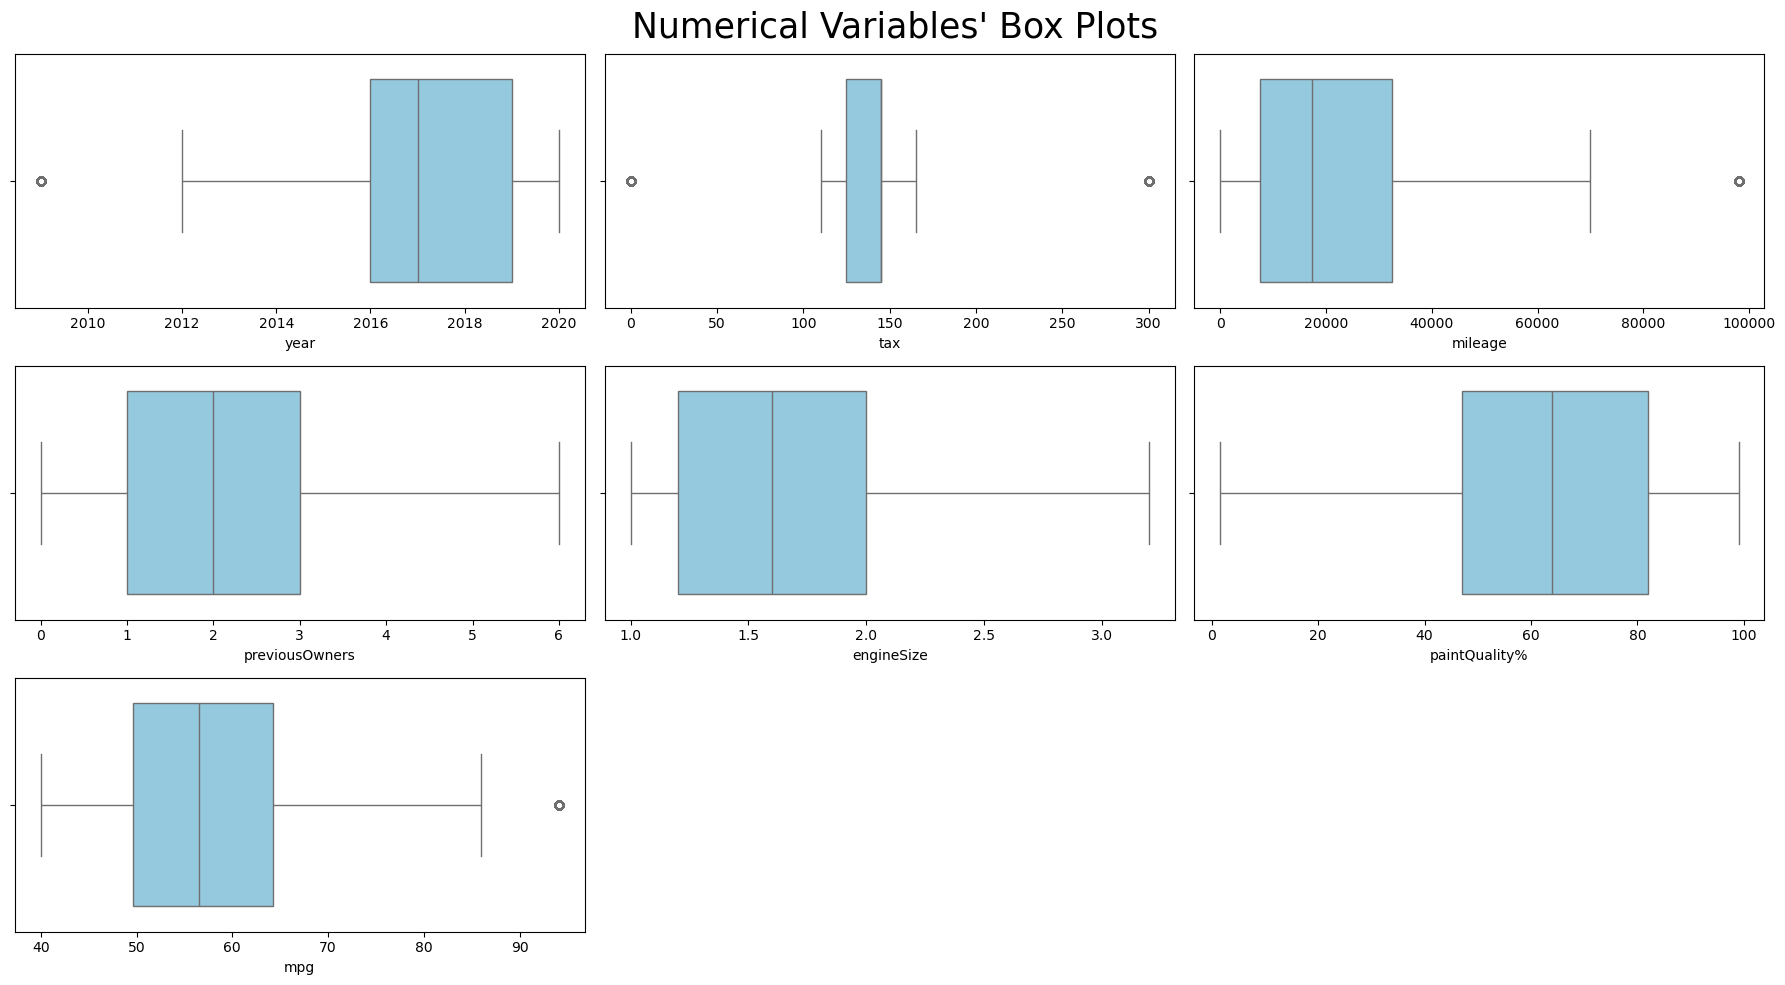

In [27]:
import seaborn as sns

numeric_features = ['year', 'tax', 'mileage', 'previousOwners', 'engineSize', 'paintQuality%', 'mpg']

fig, axes = plt.subplots(ceil(len(numeric_features) / 3 ), 3, figsize = (18,10))


for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=X[feat], ax=ax, color='skyblue')

# Delete empty plots
for ax in axes.flatten()[len(numeric_features):]:
    ax.axis('off')

plt.suptitle("Numerical Variables' Box Plots", fontsize=25)

plt.tight_layout()
plt.show()

In [28]:
# Missing_Value_Treatment
missing = Missing_Value_Treatment()
X = missing.fit_transform(X)
print("Missing Treatment works")

Missing Treatment works


In [29]:
# Typecasting
type = Typecasting()
X = type.fit_transform(X)
print("Typecasting works")

Typecasting works


In [30]:
# Test Feature_Engineering
feature_eng = Feature_Engineering()
X = feature_eng.fit_transform(X,y)
print("Feature Eng works")

Feature Eng works


In [31]:
X.isna().sum()

year                       0
mileage                    0
tax                        0
mpg                        0
engineSize                 0
paintQuality%           1891
previousOwners             0
hasDamage                  0
Brand_cleaned              0
transmission_cleaned       0
fuelType_cleaned           0
model_cleaned              0
carAge                     0
AvgUsage                   0
carSegment                 0
dtype: int64

In [31]:
# Encoder
code = Encoder()
X = code.fit_transform(X,y)
print("Encoder works")

Encoder works


In [32]:
# Scaler
scaler = Scaler()
X = scaler.fit_transform(X,y)
print("Scaler works")

Scaler works


In [33]:
X.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'carAge', 'AvgUsage', 'carSegment',
       'model_cleaned_encoded', 'Brand_cleaned_encoded',
       'fuelType_cleaned_DIESEL', 'fuelType_cleaned_ELECTRIC',
       'fuelType_cleaned_HYBRID', 'fuelType_cleaned_OTHER',
       'fuelType_cleaned_PETROL', 'transmission_cleaned_AUTOMATIC',
       'transmission_cleaned_MANUAL', 'transmission_cleaned_OTHER',
       'transmission_cleaned_SEMI-AUTO', 'transmission_cleaned_UNKNOWN'],
      dtype='object')

In [34]:
# Test Categorical_Correction
selection = Feature_Selection()
X = selection.fit_transform(X,y)
print("Feat Selection works")

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [67]:
X.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'carAge', 'AvgUsage',
       'carSegment', 'model_cleaned_encoded', 'Brand_cleaned_encoded',
       'fuelType_cleaned_DIESEL', 'fuelType_cleaned_PETROL',
       'transmission_cleaned_MANUAL', 'transmission_cleaned_SEMI-AUTO',
       'fuelType_cleaned_ELECTRIC', 'fuelType_cleaned_OTHER'],
      dtype='object')